<a href="https://colab.research.google.com/github/CateMerfeld/class_work/blob/main/classifier_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import pathlib
import glob
import os
import tempfile

In [2]:
# define var for path to image data
train_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/train/'
validation_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/validation/'

In [3]:
img_height = 160 #@param {type:"number"}
img_width = 160 #@param {type:"number"}
batch_size = 32 #@param {type:"number"}

In [4]:
# create training dataset from images in train directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3841 files belonging to 2 classes.


In [5]:
# create validation dataset from images in validation directory
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1083 files belonging to 2 classes.


The documentation for `tf.data.Dataset` objects does not discuss an attribute for class distribution. Taking the length of each class's list of images is a work around to see distribution of classes. 

In [6]:
# generate lists of edible and poisonous mushroom images and print out length of each
images = pathlib.Path(train_dir)
edible_mushrooms = list(images.glob('edible/*'))
poisonous_mushrooms = list(images.glob('poisonous/*'))
print(len(edible_mushrooms), 'edible mushroom images')
print(len(poisonous_mushrooms), 'poisonous mushroom images')

3078 edible mushroom images
763 poisonous mushroom images


In [7]:
# save these numbers for use in determining initial bias
neg = len(edible_mushrooms)
pos = len(poisonous_mushrooms)

The dataset has over four times as many edible mushroom images as poisonous ones. This may affect model performance and need to be accounted for later. 

In [8]:
# set input shape based on the channels' order
if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

Looking at the first few images from the dataset, we can see that the images are taken from different angles and distances. Data augmentation will allow us to account for some of this by artificially altering the images.

In [9]:
# set augmentation configuration for training images
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

This samle augmented image shows how data augmentation can be used to generate many variations of an image. This is especially useful since our dataset is not very large.

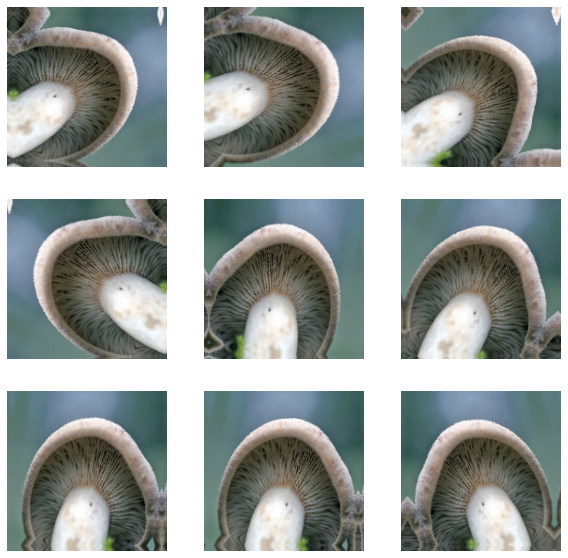

In [10]:
# visualize data augmentation on one image
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [11]:
# use buffered prefetching so I/O doesn't become blocking
AUTOTUNE = tf.data.AUTOTUNE

# dataset.cache() keeps images in memory after they're loaded off disk during the first epoch
# dataset.prefetch() overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

Using the Keras Functional API, we can link the `data_augmentation` layer with traditional CNN layers like `MaxPooling2D`.

In [34]:
epochs =  50#@param {type: "number"}
batch_size =  128#@param {type:"number"}
learning_rate =  .001#@param {type:"number"}

Since the dataset is imbalanced, accuracy alone will not show how well the model is perfmorming. It could achieve 80% accuracy by classifying everything as edible. I'll use precision, recall and AUC as metrics in addition to accuracy. 

In [13]:
# define metrics to be returned each epoch
METRICS = [
           keras.metrics.Precision(),
           keras.metrics.Recall(),
           keras.metrics.AUC(),
           keras.metrics.BinaryAccuracy()
]


def make_model(metrics=METRICS, output_bias=None):
  '''
  Sets up and compiles model using metrics and elements created above

  Arguments:
    metrics: evaluation metrics
    output_bias: optional, initial bias
  '''
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)

  # set up model pipeline with elements created above
  inputs = keras.Input(shape=(input_shape))
  x = data_augmentation(inputs)
  x = Conv2D(8, kernel_size=4, activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
  model = keras.Model(inputs, outputs)

  opt = keras.optimizers.Adam(lr=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)

  return model

Since the dataset is imbalanced, it is reasonable to expect that this model won't perform very well. With default bias initialization we should be seeing loss of about `math.log(2) = .693`. This model is currently showing a loss of more than twice that. 

In [14]:
model = make_model()
results = model.evaluate(train_ds, batch_size=batch_size, verbose=0)
results[0]

1.384013056755066

To correct for this, I'll start by changing the bias of the model. According to a TensorFlow tutorial on classification on imbalanced data, the optimal starting bias can be determined by finding the log of positive/negative samples.

In [15]:
initial_bias = np.log([pos/neg])
initial_bias[0]

-1.3947772831143677

This loss is better than what we saw with naive initialization, but still higher than we should be seeing with this initialization.

In [17]:
model = make_model(output_bias = initial_bias)
results = model.evaluate(train_ds, batch_size=batch_size, verbose=0)
results[0]

0.5236606001853943

In [18]:
# save model weights in a temporary file
initial_weights = os.path.join(tempfile.mkdtemp(), 'inital_weights')
model.save_weights(initial_weights)

In [22]:
# set up early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', # use validation auc as monitor
    verbose=1, 
    patience=10, # wait 10 epochs before early stop
    mode='max', # training will stop when val_auc stops increasing
    restore_best_weights=True # restore weights from epoch where model performed best
)

In [25]:
model = make_model()
model.load_weights(initial_weights) # use the weights saved above in the new model

# train model and store as history object
baseline_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=validation_ds,
)

Epoch 1/50
121/121 [==============================] - 3s 15ms/step - loss: 0.8658 - precision: 0.2480 - recall: 0.0175 - auc: 0.4977 - binary_accuracy: 0.7980 - val_loss: 0.4893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_accuracy: 0.8079
Epoch 2/50
121/121 [==============================] - 2s 13ms/step - loss: 0.5003 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - binary_accuracy: 0.8001 - val_loss: 0.4893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_accuracy: 0.8079
Epoch 3/50
121/121 [==============================] - 1s 12ms/step - loss: 0.5007 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - binary_accuracy: 0.8001 - val_loss: 0.4893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_accuracy: 0.8079
Epoch 4/50
121/121 [==============================] - 1s 12ms/step - loss: 0.5003 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - bina

In [ ]:
def plot_metrics(history):
  metrics = ['loss', ]

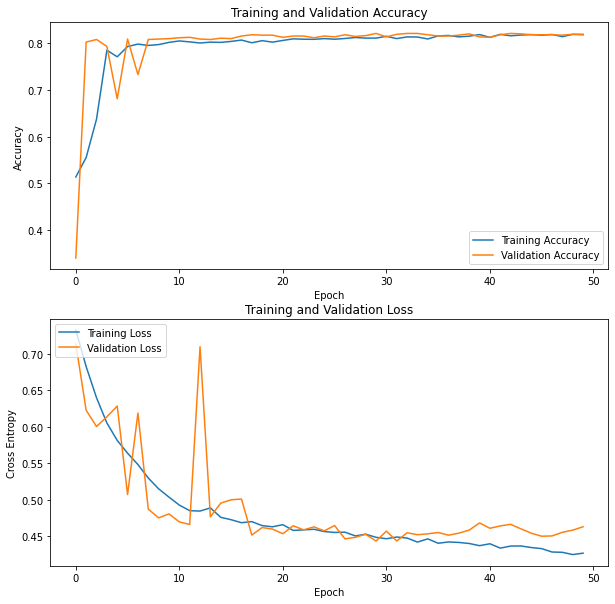

In [38]:
# get training and validation accuracy from the history object
tr_acc = baseline_history.history['binary_accuracy']
val_acc = baseline_history.history['val_binary_accuracy']

# get training and validation loss from the history object
tr_loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']

# plot accuracy and loss over epochs
epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_range, tr_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')

plt.show()

In [26]:
true_labels = tf.concat([y for x, y in validation_ds], axis=0)
predictions = model.predict(validation_ds)
preds = np.argmax(predictions, axis=1)

In [27]:
predictions = model.predict(validation_ds)
preds = np.argmax(predictions, axis=1)

In [28]:
print('Confusion matrix:\n\n',confusion_matrix(preds, true_labels))
print('\n------------------------------------------------\n')
print('Classification report:\n\n',classification_report(true_labels, preds))

Confusion matrix:

 [[875 208]
 [  0   0]]

------------------------------------------------

Classification report:

               precision    recall  f1-score   support

           0       0.81      1.00      0.89       875
           1       0.00      0.00      0.00       208

    accuracy                           0.81      1083
   macro avg       0.40      0.50      0.45      1083
weighted avg       0.65      0.81      0.72      1083



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Although this model's accuracy scores are above 80% we can see from the precision and recall that it does not perform well at all. Currently the model is classifying everything as negative(edible). 

I'll try changing the class weights to make the model weigh examples from the underrepresented class, poisonous, more heavily than edible examples.

In [32]:
# scale by total/2 in order to keep loss at a similar level
total = neg+pos
weight_0 = (1/neg)*total/2.0
weight_1 = (1/pos)*total/2.0

# set up dictionary to hold weights
class_weights = {0: weight_0, 1: weight_1}

print('Class 0 weight: ', weight_0)
print('Class 1 weight: ', weight_1)

Class 0 weight:  0.6239441195581547
Class 1 weight:  2.517038007863696


In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=validation_ds,
    class_weight=class_weights
)

Epoch 1/50
121/121 [==============================] - 3s 15ms/step - loss: 1.4022 - precision: 0.1933 - recall: 0.0581 - auc: 0.4965 - binary_accuracy: 0.7693 - val_loss: 0.4907 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_accuracy: 0.8079
Epoch 2/50
121/121 [==============================] - 1s 12ms/step - loss: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4959 - binary_accuracy: 0.8001 - val_loss: 0.4939 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_accuracy: 0.8079
Epoch 3/50
121/121 [==============================] - 1s 12ms/step - loss: 0.8606 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5079 - binary_accuracy: 0.8001 - val_loss: 0.4987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_accuracy: 0.8079
Epoch 4/50
121/121 [==============================] - 1s 12ms/step - loss: 0.8352 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4905 - bina

In [36]:
true_labels = tf.concat([y for x, y in validation_ds], axis=0)
predictions = weighted_model.predict(validation_ds)
preds = np.argmax(predictions, axis=1)

In [37]:
predictions = weighted_model.predict(validation_ds)
preds = np.argmax(predictions, axis=1)

In [38]:
print('Confusion matrix:\n\n',confusion_matrix(preds, true_labels))
print('\n------------------------------------------------\n')
print('Classification report:\n\n',classification_report(true_labels, preds))

Confusion matrix:

 [[875 208]
 [  0   0]]

------------------------------------------------

Classification report:

               precision    recall  f1-score   support

           0       0.81      1.00      0.89       875
           1       0.00      0.00      0.00       208

    accuracy                           0.81      1083
   macro avg       0.40      0.50      0.45      1083
weighted avg       0.65      0.81      0.72      1083



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
epochs =  50#@param {type: "number"}
batch_size =  64#@param {type:"number"}
learning_rate =  .0001#@param {type:"number"}

Since the dataset is imbalanced, accuracy alone will not show how well the model is perfmorming. It could achieve 80% accuracy by classifying everything as edible. I'll use precision, recall and AUC as metrics in addition to accuracy. 

In [ ]:
# define metrics to be returned each epoch
METRICS = [
           keras.metrics.Precision(),
           keras.metrics.Recall(),
           keras.metrics.AUC(),
           keras.metrics.BinaryAccuracy()
]
# compile model
opt = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

In [ ]:
# train model and store as history object
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
)

Epoch 1/50
121/121 [==============================] - 4s 21ms/step - loss: 0.7417 - precision_2: 0.2082 - recall_2: 0.5457 - auc_2: 0.5252 - binary_accuracy: 0.5150 - val_loss: 0.7134 - val_precision_2: 0.2138 - val_recall_2: 0.9087 - val_auc_2: 0.5569 - val_binary_accuracy: 0.3407
Epoch 2/50
121/121 [==============================] - 2s 16ms/step - loss: 0.6951 - precision_2: 0.1966 - recall_2: 0.4657 - auc_2: 0.5186 - binary_accuracy: 0.5320 - val_loss: 0.6224 - val_precision_2: 0.3158 - val_recall_2: 0.0288 - val_auc_2: 0.6408 - val_binary_accuracy: 0.8015
Epoch 3/50
121/121 [==============================] - 2s 16ms/step - loss: 0.6495 - precision_2: 0.2049 - recall_2: 0.3613 - auc_2: 0.5563 - binary_accuracy: 0.6058 - val_loss: 0.6002 - val_precision_2: 0.3333 - val_recall_2: 0.0048 - val_auc_2: 0.6578 - val_binary_accuracy: 0.8070
Epoch 4/50
121/121 [==============================] - 2s 16ms/step - loss: 0.6110 - precision_2: 0.2281 - recall_2: 0.0837 - auc_2: 0.5824 - binary_acc

In [ ]:
# The base model, MobileNetV2, expects pixel values in [-1,1]. 
# This preprocessing is included with the model and will rescale the pixel values
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# freeze convolutional base so that weights will not be updated during training
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

In [ ]:
inputs = keras.Input(shape=(input_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

In [ ]:
#@markdown ### Set learning rate and number of epochs:
learning_rate =  .0001#@param {type:"number"}
epochs = 10 #@param {type: "number"}

In [ ]:
opt = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
loss, accuracy = model.evaluate(validation_ds)

34/34 [==============================] - 2s 26ms/step - loss: 3.0160 - accuracy: 0.8045


In [ ]:
# train model and store as history object
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
)

Epoch 1/10
121/121 [==============================] - 7s 34ms/step - loss: 2.3306 - accuracy: 0.7402 - val_loss: 0.5182 - val_accuracy: 0.8079
Epoch 2/10
121/121 [==============================] - 4s 33ms/step - loss: 2.0571 - accuracy: 0.7126 - val_loss: 0.5199 - val_accuracy: 0.8079
Epoch 3/10
121/121 [==============================] - 4s 33ms/step - loss: 1.9752 - accuracy: 0.7040 - val_loss: 2.4473 - val_accuracy: 0.8079
Epoch 4/10
121/121 [==============================] - 4s 33ms/step - loss: 2.0142 - accuracy: 0.7248 - val_loss: 2.9524 - val_accuracy: 0.8079
Epoch 5/10
121/121 [==============================] - 4s 33ms/step - loss: 2.0524 - accuracy: 0.7232 - val_loss: 1.0730 - val_accuracy: 0.8079
Epoch 6/10
121/121 [==============================] - 4s 33ms/step - loss: 2.2463 - accuracy: 0.6100 - val_loss: 0.4905 - val_accuracy: 0.8079
Epoch 7/10
121/121 [==============================] - 4s 33ms/step - loss: 2.0697 - accuracy: 0.6540 - val_loss: 0.5050 - val_accuracy: 0.8079

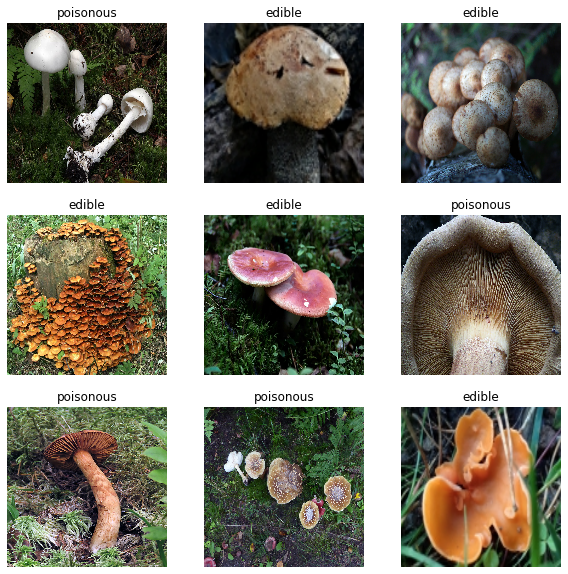

In [ ]:
# retrieve class names from dataset
class_names = train_ds.class_names

# plot first 9 images from training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')